#Librerias importadas


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)

RANDOM_STATE = 42

#**Carga de datos**

Codigo para conectar mi drive al google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/trabajo machine lerning/lending_dataset.xlsx"
df = pd.read_excel(path)

print(df.shape)
df.head()


(19908, 20)


,index,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,revol_util,application_type,pub_rec_bankruptcies
0,1,2400,36,15.9600,84.3300,C,NaN,10+ years,RENT,12252.0000,Not Verified,Fully Paid,s,small_business,IL,8.7200,0.0000,98.5000,Individual,0.0000
1,2,10000,36,13.4900,339.3100,C,AIR RESOURCES BOARD,10+ years,RENT,49200.0000,Source Verified,Fully Paid,s,other,CA,20.0000,0.0000,21.0000,Individual,0.0000
2,3,3000,36,18.6400,109.4300,E,MKC Accounting,9 years,RENT,48000.0000,Source Verified,Fully Paid,s,car,CA,5.3500,0.0000,87.5000,Individual,0.0000
3,4,5600,60,21.2800,152.3900,F,NaN,4 years,OWN,40000.0000,Source Verified,Charged Off,s,small_business,CA,5.5500,0.0000,32.6000,Individual,0.0000
4,5,5375,60,12.6900,121.4500,B,Starbucks,< 1 year,RENT,15000.0000,Verified,Charged Off,s,other,TX,18.0800,0.0000,36.5000,Individual,0.0000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19908 entries, 0 to 19907
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 19908 non-null  int64  
 1   loan_amnt             19908 non-null  int64  
 2   term                  19908 non-null  int64  
 3   int_rate              19908 non-null  float64
 4   installment           19908 non-null  float64
 5   grade                 19908 non-null  object 
 6   emp_title             18723 non-null  object 
 7   emp_length            19406 non-null  object 
 8   home_ownership        19905 non-null  object 
 9   annual_inc            19905 non-null  float64
 10  verification_status   19905 non-null  object 
 11  loan_status           19905 non-null  object 
 12  pymnt_plan            19908 non-null  object 
 13  purpose               19905 non-null  object 
 14  addr_state            19899 non-null  object 
 15  dti                

Recuento de cuantos variables existen en cada columna para saber si se debe mantener o no. En el caso del **aplication_type** se elimina porque hay 19906 variables llamadas individual contra 2 variables que toman el valor de 1. Con respecto a la columna **pymnt_plan** se elimna porque contiene una unica variable llamada "s". Por último, se elimina la columna index porque no aporta en nada como variable explicativa.


In [5]:
df['application_type'].value_counts(dropna=False)

,count
application_type,
Individual,19906
1,2


In [6]:
df['pymnt_plan'].value_counts(dropna=False)

,count
pymnt_plan,
s,19908


In [7]:
df_1 = df.drop(columns=['index', 'pymnt_plan', 'application_type'])

###**Separación de variables numéricas y categóricas**

Con el objetivo de estructurar el análisis exploratorio y el preprocesamiento de manera sistemática, se separaron las variables del dataset según su tipo en dos grupos: numéricas y categóricas.

Esta distinción permite aplicar diagnósticos y transformaciones específicas a cada tipo de variable, dado que las variables numéricas requieren análisis de distribución, outliers y escalamiento, mientras que las variables categóricas requieren análisis de cardinalidad, frecuencias y codificación.

Para ello, se identificaron automáticamente las variables numéricas y categóricas a partir de su tipo de dato, evitando una clasificación manual y asegurando la reproducibilidad del flujo de trabajo. Esta separación sirve como base para el análisis descriptivo, el diagnóstico de calidad de datos y la posterior construcción del pipeline de preprocesamiento.

In [8]:
num_cols = df_1.select_dtypes(include="number").columns.tolist()
cat_cols = df_1.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Variables numéricas: {len(num_cols)}")
print(f"Variables categóricas: {len(cat_cols)}")

Variables numéricas: 9
Variables categóricas: 8


##1.- Análisis descriptivo de variables numéricas vs categóricas
Como parte del análisis estadístico inicial, se calcularon estadísticos descriptivos para las variables numéricas del dataset. Este análisis permite caracterizar la distribución de cada variable en términos de nivel central, dispersión y rango, así como identificar posibles valores atípicos o inconsistencias en los datos.

La tabla descriptiva incluye indicadores como el número de observaciones válidas, la media, la desviación estándar, los cuartiles y los valores mínimo y máximo, lo que facilita la detección temprana de problemas de calidad de datos, diferencias de escala entre variables y señales que orientan decisiones posteriores de preprocesamiento, tales como imputación de valores faltantes, transformaciones o escalado.

###**1.1.- analisis de las variables numericas**

#**estadisticos**

In [9]:
desc_num = df_1[num_cols].describe().T
desc_num

,count,mean,std,min,25%,50%,75%,max
loan_amnt,19908.0000,11353.8464,7463.7005,500.0000,5750.0000,10000.0000,15000.0000,35000.0000
term,19908.0000,42.0952,10.4470,36.0000,36.0000,36.0000,60.0000,60.0000
int_rate,19908.0000,12.0897,3.6983,5.4200,9.4500,11.8600,14.6100,24.4000
installment,19908.0000,330.6143,210.5574,15.6900,171.2875,285.7800,440.8150,1302.6900
annual_inc,19905.0000,71074.7134,69810.7207,4000.0000,42000.0000,60000.0000,85000.0000,6000000.0000
dti,19897.0000,13.0099,6.6640,0.0000,7.8400,13.0800,18.2000,29.9900
delinq_2yrs,19899.0000,0.1446,0.4935,0.0000,0.0000,0.0000,0.0000,11.0000
revol_util,19880.0000,49.7354,49.8168,0.0000,26.5000,50.3000,72.8000,5829.0000
pub_rec_bankruptcies,19587.0000,0.0380,0.1914,0.0000,0.0000,0.0000,0.0000,2.0000


#**cuantiles**
Se calcularon cuantiles seleccionados de las variables numéricas para analizar el comportamiento de las colas de la distribución e identificar posibles valores extremos.


In [10]:
quantiles_num = (
    df_1[num_cols]
    .quantile([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])
    .T
)

quantiles_num


,0.0100,0.0500,0.1000,0.2500,0.5000,0.7500,0.9000,0.9500,0.9900
loan_amnt,1200.0000,2400.0000,3500.0000,5750.0000,10000.0000,15000.0000,22400.0000,25000.0000,35000.0000
term,36.0000,36.0000,36.0000,36.0000,36.0000,60.0000,60.0000,60.0000,60.0000
int_rate,5.4200,6.5400,7.1400,9.4500,11.8600,14.6100,16.8900,18.5400,20.9900
installment,39.1449,75.4800,102.8400,171.2875,285.7800,440.8150,636.3690,773.4000,933.1337
annual_inc,14400.0000,24000.0000,30000.0000,42000.0000,60000.0000,85000.0000,120000.0000,150000.0000,248003.8400
dti,0.3500,1.9800,3.7900,7.8400,13.0800,18.2000,22.1300,23.6900,26.2600
delinq_2yrs,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,2.0000
revol_util,0.0000,2.9000,9.0000,26.5000,50.3000,72.8000,88.0000,93.7050,98.5000
pub_rec_bankruptcies,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


#**%Missing**
Revisando las variables numéricas, se observa que la mayoría están completas. La columna `pub_rec_bankruptcies` tiene el mayor porcentaje de valores faltantes (1.61%), mientras que otras como `loan_amnt`, `term` e `int_rate` no tienen valores faltantes. Esto indica que los datos numéricos están en buen estado, con muy pocos valores a imputar.


In [11]:
# Dtypes
df_1[num_cols].info()
# Missing real
df_1[num_cols].isna().mean().sort_values(ascending=False)
#porcentanje de nan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19908 entries, 0 to 19907
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             19908 non-null  int64  
 1   term                  19908 non-null  int64  
 2   int_rate              19908 non-null  float64
 3   installment           19908 non-null  float64
 4   annual_inc            19905 non-null  float64
 5   dti                   19897 non-null  float64
 6   delinq_2yrs           19899 non-null  float64
 7   revol_util            19880 non-null  float64
 8   pub_rec_bankruptcies  19587 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.4 MB


,0
pub_rec_bankruptcies,0.0161
revol_util,0.0014
dti,0.0006
delinq_2yrs,0.0005
annual_inc,0.0002
loan_amnt,0.0000
installment,0.0000
term,0.0000
int_rate,0.0000


#**Top-5 valores más frecuentes**
Este código analiza las variables numéricas y muestra los cinco valores más frecuentes en cada una. Para cada valor se indica cuántas veces aparece (`count`) y qué porcentaje representa del total (`percent`). Esto permite identificar valores dominantes o muy repetidos, como ceros u otros números comunes, y entender mejor la distribución de los datos antes de hacer análisis o modelado.


In [12]:
# Recorremos todas las columnas numéricas
for col in num_cols:
    print(f"\nVariable: {col}")

    # Conteo de los 5 valores más frecuentes
    top_values = df_1[col].value_counts().head(5)

    # Porcentaje de esos valores
    top_percent = df_1[col].value_counts(normalize=True).head(5) * 100

    # Crear un DataFrame para mostrar count y porcentaje
    top_table = pd.DataFrame({
        "count": top_values,
        "percent": top_percent
    })

    # Mostrar la tabla
    print(top_table)


Variable: loan_amnt
           count  percent
loan_amnt                
10000       1466   7.3639
12000       1208   6.0679
5000        1026   5.1537
6000         994   4.9930
15000        984   4.9427

Variable: term
      count  percent
term                
36    14852  74.6032
60     5056  25.3968

Variable: int_rate
          count  percent
int_rate                
10.9900     492   2.4714
11.4900     407   2.0444
13.4900     406   2.0394
7.5100      384   1.9289
7.8800      381   1.9138

Variable: installment
             count  percent
installment                
311.1100        37   0.1859
180.9600        37   0.1859
368.4500        33   0.1658
311.0200        30   0.1507
325.7400        28   0.1406

Variable: annual_inc
            count  percent
annual_inc                
60000.0000    794   3.9889
50000.0000    554   2.7832
40000.0000    445   2.2356
45000.0000    431   2.1653
75000.0000    425   2.1351

Variable: dti
         count  percent
dti                    
0.0000   

###**1.1.- analisis de las variables categoricas**

#**cardinalidad**
Se calculó la cardinalidad de las variables categóricas para identificar columnas con alta o baja variabilidad que puedan requerir tratamiento especial o eliminación antes del modelado.

In [13]:
#cantidad de cateogiras en cada columna (cardinalidad)
card_cat = (
    df_1[cat_cols]
    .nunique(dropna=False)
    .sort_values(ascending=False)
    .to_frame("n_unique")
)

card_cat


,n_unique
emp_title,15048
purpose,15
emp_length,12
addr_state,9
grade,7
home_ownership,6
verification_status,4
loan_status,3


#**%Missing**
Se busca el porcentaje de missin en cada columna con variables categoricas

In [14]:
df_1[cat_cols].isna().mean().sort_values(ascending=False)

,0
emp_title,0.0595
emp_length,0.0252
addr_state,0.0005
home_ownership,0.0002
loan_status,0.0002
verification_status,0.0002
purpose,0.0002
grade,0.0000


#**Top-10 valores más frecuentes (variables categoricas)**

In [15]:
for col in cat_cols:
    print(f"\nVariable: {col}")

    # Conteo de los 10 valores más frecuentes (incluyendo "Missing")
    top_values = df_1[col].value_counts().head(10)

    # Porcentaje de esos valores
    top_percent = df_1[col].value_counts(normalize=True).head(10) * 100

    # Crear tabla con count y percent
    top_table = pd.DataFrame({
        "count": top_values,
        "percent": top_percent
    })

    # Mostrar la tabla
    print(top_table)



Variable: grade
       count  percent
grade                
B       6065  30.4651
A       4875  24.4876
C       4087  20.5294
D       2748  13.8035
E       1434   7.2031
F        540   2.7125
G        159   0.7987

Variable: emp_title
                     count  percent
emp_title                          
Bank of America         53   0.2831
Kaiser Permanente       50   0.2671
State of California     42   0.2243
US Army                 40   0.2136
AT&T                    36   0.1923
JP Morgan Chase         27   0.1442
IBM                     25   0.1335
Verizon                 24   0.1282
UPS                     23   0.1228
Columbia University     21   0.1122

Variable: emp_length
            count  percent
emp_length                
10+ years    4249  21.8953
< 1 year     2304  11.8726
2 years      2218  11.4295
3 years      2108  10.8626
4 years      1871   9.6413
5 years      1649   8.4974
1 year       1636   8.4304
6 years      1151   5.9312
7 years       867   4.4677
8 years      

##2.- Análisis de calidad (diagnóstico)

##**2.1.- numericas**

**Dtypes incorrectos**

In [16]:
diagnostic = []

for col in num_cols:
    # Número de NaN antes de convertir
    nan_before = df_1[col].isna().sum()

    # Intentar convertir a numérico
    coerced = pd.to_numeric(df_1[col], errors="coerce")

    # Número de NaN después de convertir
    nan_after = coerced.isna().sum()

    diagnostic.append({
        "column": col,
        "dtype_original": df_1[col].dtype,
        "NaN_before": nan_before,
        "NaN_after_coerce": nan_after
    })

# Crear DataFrame de diagnóstico
diagnostic_df = pd.DataFrame(diagnostic)
diagnostic_df


,column,dtype_original,NaN_before,NaN_after_coerce
0,loan_amnt,int64,0,0
1,term,int64,0,0
2,int_rate,float64,0,0
3,installment,float64,0,0
4,annual_inc,float64,3,3
5,dti,float64,11,11
6,delinq_2yrs,float64,9,9
7,revol_util,float64,28,28
8,pub_rec_bankruptcies,float64,321,321


#**missing real**
Este bloque calcula el porcentaje de valores faltantes nan en las columnas numericas. Luego ordena las columnas de mayor a menor porcentaje de faltantes para identificar cuales necesitan limpieza o imputacion antes del analisis o modelado.

In [17]:
# Porcentaje de valores faltantes en columnas numéricas
missing_num = df_1[num_cols].isna().mean().sort_values(ascending=False)

# Crear tabla con ranking
missing_num_table = pd.DataFrame({
    "column": missing_num.index,
    "%missing": missing_num.values * 100
})

missing_num_table


,column,%missing
0,pub_rec_bankruptcies,1.6124
1,revol_util,0.1406
2,dti,0.0553
3,delinq_2yrs,0.0452
4,annual_inc,0.0151
5,loan_amnt,0.0000
6,installment,0.0000
7,term,0.0000
8,int_rate,0.0000


#**outliers**
Este bloque calcula para cada variable numerica los valores minimo (min), percentil 1% (p1), mediana (p50), percentil 99% (p99) y maximo (max). Esto permite detectar valores atipicos (outliers) y entender la distribucion de los datos, identificando posbiles valores extremos que podrian influir en el analisis o modelado.

In [18]:
# Crear tabla resumen de percentiles y extremos
outliers_table = df_1[num_cols].agg(
    ["min", lambda x: x.quantile(0.01), "median", lambda x: x.quantile(0.99), "max"]
)

# Renombrar columnas
outliers_table.index = ["min", "p1", "p50", "p99", "max"]

outliers_table


,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,revol_util,pub_rec_bankruptcies
min,500.0000,36.0000,5.4200,15.6900,4000.0000,0.0000,0.0000,0.0000,0.0000
p1,1200.0000,36.0000,5.4200,39.1449,14400.0000,0.3500,0.0000,0.0000,0.0000
p50,10000.0000,36.0000,11.8600,285.7800,60000.0000,13.0800,0.0000,50.3000,0.0000
p99,35000.0000,60.0000,20.9900,933.1337,248003.8400,26.2600,2.0000,98.5000,1.0000
max,35000.0000,60.0000,24.4000,1302.6900,6000000.0000,29.9900,11.0000,5829.0000,2.0000


#**duplicados**
Se verificó la presencia de observaciones duplicadas con el fin de evaluar la consistencia del dataset antes del modelado.

In [19]:
#Diagnóstico de calidad de datos
n_duplicates = df_1.duplicated().sum()
print("Duplicados:", n_duplicates)


Duplicados: 0


#2.2.- Categoricas

#**Missing**

In [20]:
# Porcentaje de "Missing" en columnas categóricas
missing_cat = (df_1[cat_cols] == "Missing").mean().sort_values(ascending=False)

# Crear tabla
missing_cat_table = pd.DataFrame({
    "column": missing_cat.index,
    "%missing": missing_cat.values * 100
})

missing_cat_table


,column,%missing
0,grade,0.0000
1,emp_title,0.0000
2,emp_length,0.0000
3,home_ownership,0.0000
4,verification_status,0.0000
5,loan_status,0.0000
6,purpose,0.0000
7,addr_state,0.0000


#**Missing codificado**
Se identificaron valores faltantes codificados como texto en las variables categóricas para detectar problemas de calidad que no se reflejan como NaN

In [21]:
for col in cat_cols:
    fake_missing = df_1[col].astype(str).str.strip().isin(["", "?", "nan"]).sum()
    if fake_missing > 0:
        print(f"{col}: {fake_missing} valores tipo missing codificado")


emp_title: 1185 valores tipo missing codificado
emp_length: 502 valores tipo missing codificado
home_ownership: 3 valores tipo missing codificado
verification_status: 3 valores tipo missing codificado
loan_status: 3 valores tipo missing codificado
purpose: 3 valores tipo missing codificado
addr_state: 9 valores tipo missing codificado


#**categorias con baja frecuencia**
Este bloque identifica categorias con baja frecuencia en las columnas categoricas. Se calcula la proporcion de cada categoria y se seleccionan aquellas que representan menos del 1% de los registros. Esto ayuda a detectar categorias inestables que podrian agruparse como "otros" para mejorar la consistencia y estabilidad del analisis o del modelo.

In [22]:
# Definir un umbral de frecuencia relativa (por ejemplo <1%)
threshold = 0.01

for col in cat_cols:
    # Frecuencia relativa de cada categoría
    freqs = df_1[col].value_counts(normalize=True)

    # Seleccionar categorías con frecuencia menor al umbral
    rare_categories = freqs[freqs < threshold]

    if not rare_categories.empty:
        print(f"\nVariable: {col} - Categorías con baja frecuencia (<{threshold*100:.0f}%):")
        print(pd.DataFrame({
            "category": rare_categories.index,
            "percent": rare_categories.values * 100
        }))



Variable: grade - Categorías con baja frecuencia (<1%):
  category  percent
0        G   0.7987

Variable: emp_title - Categorías con baja frecuencia (<1%):
                                 category  percent
0                         Bank of America   0.2831
1                       Kaiser Permanente   0.2671
2                     State of California   0.2243
3                                 US Army   0.2136
4                                    AT&T   0.1923
...                                   ...      ...
15042  Northwestern Mutual Life Insurance   0.0053
15043           Suniland Associates, LTD.   0.0053
15044                               NYCPD   0.0053
15045                    Equality Florida   0.0053
15046           Cuban Medical Association   0.0053

[15047 rows x 2 columns]

Variable: home_ownership - Categorías con baja frecuencia (<1%):
  category  percent
0    OTHER   0.2210
1     NONE   0.0050

Variable: purpose - Categorías con baja frecuencia (<1%):
           category

#**Valores inesperados**
Este bloque muestra todos los avlores unicos de cada columna categorica. Esto permite identificar errores de tipeo, inconsistencias o categorias inesperadas que podrian necesitar correccion o consolidacion antes del analisis o modelado.


In [23]:
for col in cat_cols:
    print(f"\nVariable: {col} - Valores únicos y conteo:")

    # Contar todos los valores, incluyendo Missing
    counts = df_1[col].value_counts(dropna=False)

    # Mostrar tabla
    print(pd.DataFrame({
        "value": counts.index,
        "count": counts.values
    }))



Variable: grade - Valores únicos y conteo:
  value  count
0     B   6065
1     A   4875
2     C   4087
3     D   2748
4     E   1434
5     F    540
6     G    159

Variable: emp_title - Valores únicos y conteo:
                                    value  count
0                                     NaN   1185
1                         Bank of America     53
2                       Kaiser Permanente     50
3                     State of California     42
4                                 US Army     40
...                                   ...    ...
15043  Northwestern Mutual Life Insurance      1
15044           Suniland Associates, LTD.      1
15045                               NYCPD      1
15046                    Equality Florida      1
15047           Cuban Medical Association      1

[15048 rows x 2 columns]

Variable: emp_length - Valores únicos y conteo:
        value  count
0   10+ years   4249
1    < 1 year   2304
2     2 years   2218
3     3 years   2108
4     4 years   1871

#**3.-reprocesamiento**

#**3.1.-numericas**

#**imputacion**
Se imputa valores a las nan. En el caso de las variables numericas que son nan se les imputa su mediana. Es decir, se les reemplaza por su mediana.

In [24]:
num_imputer = SimpleImputer(strategy="median")
df_1[num_cols] = num_imputer.fit_transform(df_1[num_cols])

In [25]:
df_1[num_cols].dtypes


,0
loan_amnt,float64
term,float64
int_rate,float64
installment,float64
annual_inc,float64
dti,float64
delinq_2yrs,float64
revol_util,float64
pub_rec_bankruptcies,float64


In [26]:
df_1[num_cols].apply(lambda x: pd.to_numeric(x, errors="coerce").isna().sum())


,0
loan_amnt,0
term,0
int_rate,0
installment,0
annual_inc,0
dti,0
delinq_2yrs,0
revol_util,0
pub_rec_bankruptcies,0


#**LOG para comparar grafico antes y luego del log**

In [27]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

# Transformador log
log_transformer = FunctionTransformer(np.log, validate=True)

# Columnas a transformar
cols_to_log = ["loan_amnt", "annual_inc"]

# Copia limpia
df_3 = df_1.copy()

# Agregar columnas log sin tocar las originales
df_3[[f"log_{c}" for c in cols_to_log]] = log_transformer.fit_transform(
    df_3[cols_to_log]
)


#**Log**
Aplica la transformación logarítmica (`log`) a columnas numéricas positivas con distribución sesgada para reducir la asimetría y el efecto de outliers. Solo se transforma `loan_amnt` y `annual_inc`, y se indica qué columnas fueron modificadas.



In [29]:
from sklearn.preprocessing import FunctionTransformer
# Crear transformador log
log_transformer = FunctionTransformer(np.log, validate=True)

# Columnas a transformar
cols_to_log = ["loan_amnt", "annual_inc"]

# Aplicar log a esas columnas
df_1[cols_to_log] = log_transformer.fit_transform(df_1[cols_to_log])


#**3.2.- Categoricas**

#**Limpieza de strip y nan codificado**
Este bloque convierte todas las columnas categoricas a texto, elimina espacios al inicio y al final de cada valor, y reemplaza "?" o cadenas vacias "" por valores faltantes NaN. Esto permite que los datos categoricos esten limpios y listos para su analisis o imputacion.

In [31]:
df_1[cat_cols] = df_1[cat_cols].apply(
    lambda s: s.str.strip().replace({"?": np.nan, "": np.nan})
)

#**Imputación**
Las variables categoricas se reemplaza por una constante llamada Missing.


In [32]:
cat_imputer = SimpleImputer(strategy="constant", fill_value="Missing")
df_1[cat_cols] = cat_imputer.fit_transform(df_1[cat_cols])

#**validacion si se imputo y ahora salen missing**

In [33]:
df_1["emp_title"].value_counts()

,count
emp_title,
Missing,1186
Bank of America,53
Kaiser Permanente,50
State of California,43
US Army,41
...,...
Value Air,1
Osram Sylvania,1
Archdiocese of Galveston Houston,1


#**Verificación de limpieza de nan tanto para las columnas numericas y categoricas**

Esta línea de código calcula el mayor porcentaje de valores faltantes (NaN) entre las columnas numéricas y categóricas del DataFrame. El resultado es (0.0, 0.0), lo que significa que ni las variables numéricas ni las categóricas tienen valores faltantes. Esto ocurre porque los datos ya fueron imputados previamente (las columnas numéricas con la mediana y las categóricas con el valor "Missing"), dejando el DataFrame completamente lleno.


In [34]:
df_1[num_cols].isna().mean().max(), df_1[cat_cols].isna().mean().max()

(0.0, 0.0)

#**4) Análisis Exploratorio (EDA univariado) y Visualización**

#**estadisticos**

In [35]:
desc_num = df_1[num_cols].describe().T
desc_num

,count,mean,std,min,25%,50%,75%,max
loan_amnt,19908.0000,9.1045,0.7250,6.2146,8.6570,9.2103,9.6158,10.4631
term,19908.0000,42.0952,10.4470,36.0000,36.0000,36.0000,60.0000,60.0000
int_rate,19908.0000,12.0897,3.6983,5.4200,9.4500,11.8600,14.6100,24.4000
installment,19908.0000,330.6143,210.5574,15.6900,171.2875,285.7800,440.8150,1302.6900
annual_inc,19908.0000,10.9992,0.5639,8.2940,10.6454,11.0021,11.3504,15.6073
dti,19908.0000,13.0099,6.6621,0.0000,7.8400,13.0800,18.2000,29.9900
delinq_2yrs,19908.0000,0.1445,0.4934,0.0000,0.0000,0.0000,0.0000,11.0000
revol_util,19908.0000,49.7362,49.7818,0.0000,26.5000,50.3000,72.8000,5829.0000
pub_rec_bankruptcies,19908.0000,0.0374,0.1899,0.0000,0.0000,0.0000,0.0000,2.0000


#**cuantiles**
Se calcularon cuantiles seleccionados de las variables numéricas para analizar el comportamiento de las colas de la distribución e identificar posibles valores extremos.


In [36]:
quantiles_num = (
    df_1[num_cols]
    .quantile([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])
    .T
)

quantiles_num


,0.0100,0.0500,0.1000,0.2500,0.5000,0.7500,0.9000,0.9500,0.9900
loan_amnt,7.0901,7.7832,8.1605,8.6570,9.2103,9.6158,10.0168,10.1266,10.4631
term,36.0000,36.0000,36.0000,36.0000,36.0000,60.0000,60.0000,60.0000,60.0000
int_rate,5.4200,6.5400,7.1400,9.4500,11.8600,14.6100,16.8900,18.5400,20.9900
installment,39.1449,75.4800,102.8400,171.2875,285.7800,440.8150,636.3690,773.4000,933.1337
annual_inc,9.5750,10.0858,10.3090,10.6454,11.0021,11.3504,11.6952,11.9184,12.4212
dti,0.3507,1.9835,3.7970,7.8400,13.0800,18.2000,22.1300,23.6900,26.2600
delinq_2yrs,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,2.0000
revol_util,0.0000,2.9000,9.0000,26.5000,50.3000,72.8000,88.0000,93.7000,98.5000
pub_rec_bankruptcies,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


#**%Missing**

In [37]:
# Dtypes
df_1[num_cols].info()
# Missing real
df_1[num_cols].isna().mean().sort_values(ascending=False)
#porcentanje de nan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19908 entries, 0 to 19907
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             19908 non-null  float64
 1   term                  19908 non-null  float64
 2   int_rate              19908 non-null  float64
 3   installment           19908 non-null  float64
 4   annual_inc            19908 non-null  float64
 5   dti                   19908 non-null  float64
 6   delinq_2yrs           19908 non-null  float64
 7   revol_util            19908 non-null  float64
 8   pub_rec_bankruptcies  19908 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,0
loan_amnt,0.0000
term,0.0000
int_rate,0.0000
installment,0.0000
annual_inc,0.0000
dti,0.0000
delinq_2yrs,0.0000
revol_util,0.0000
pub_rec_bankruptcies,0.0000


#**Top-5 valores más frecuentes**

In [38]:
# Recorremos todas las columnas numéricas
for col in num_cols:
    print(f"\nVariable: {col}")

    # Conteo de los 5 valores más frecuentes
    top_values = df_1[col].value_counts().head(5)

    # Porcentaje de esos valores
    top_percent = df_1[col].value_counts(normalize=True).head(5) * 100

    # Crear un DataFrame para mostrar count y porcentaje
    top_table = pd.DataFrame({
        "count": top_values,
        "percent": top_percent
    })

    # Mostrar la tabla
    print(top_table)


Variable: loan_amnt
           count  percent
loan_amnt                
9.2103      1466   7.3639
9.3927      1208   6.0679
8.5172      1026   5.1537
8.6995       994   4.9930
9.6158       984   4.9427

Variable: term
         count  percent
term                   
36.0000  14852  74.6032
60.0000   5056  25.3968

Variable: int_rate
          count  percent
int_rate                
10.9900     492   2.4714
11.4900     407   2.0444
13.4900     406   2.0394
7.5100      384   1.9289
7.8800      381   1.9138

Variable: installment
             count  percent
installment                
311.1100        37   0.1859
180.9600        37   0.1859
368.4500        33   0.1658
311.0200        30   0.1507
325.7400        28   0.1406

Variable: annual_inc
            count  percent
annual_inc                
11.0021       797   4.0034
10.8198       554   2.7828
10.5966       445   2.2353
10.7144       431   2.1650
11.2252       425   2.1348

Variable: dti
         count  percent
dti                  

#**Graficas**

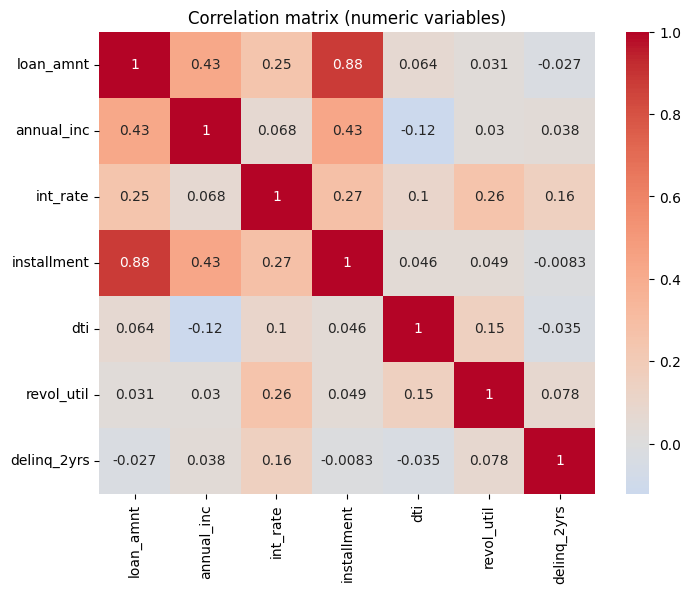

In [39]:
num_cols = ['loan_amnt', 'annual_inc', 'int_rate', 'installment',
            'dti', 'revol_util', 'delinq_2yrs']

corr = df_1[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix (numeric variables)')
plt.show()


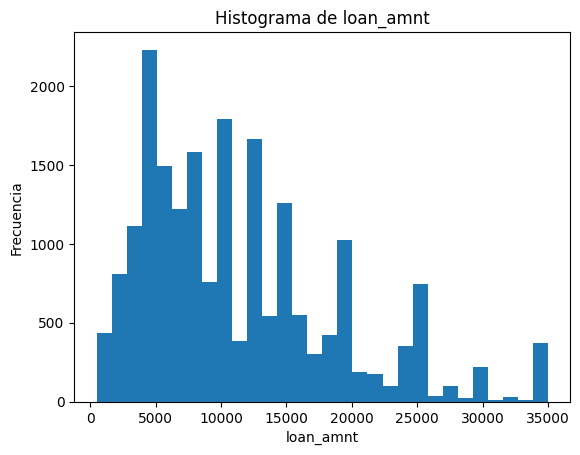

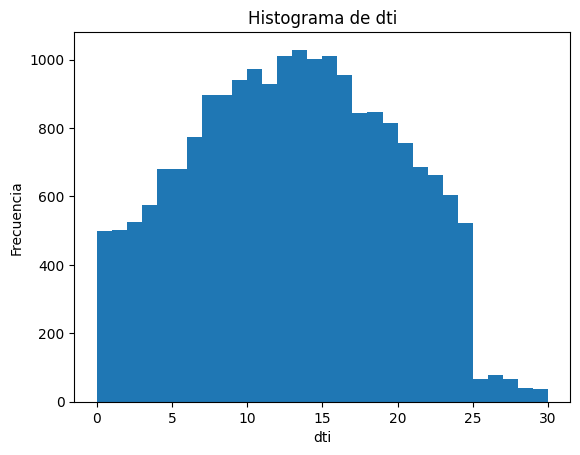

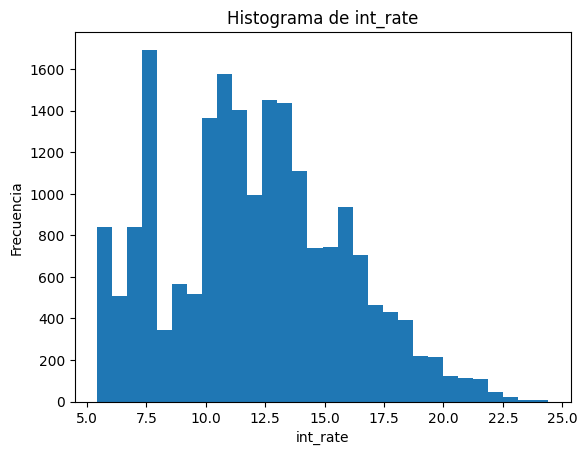

In [40]:
import matplotlib.pyplot as plt

num_cols = ["loan_amnt", "dti", "int_rate"]

for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()


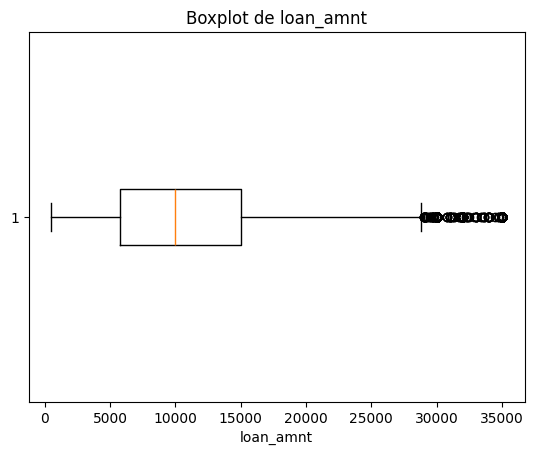

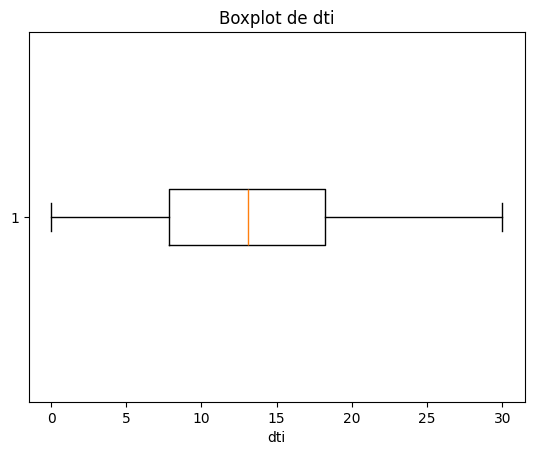

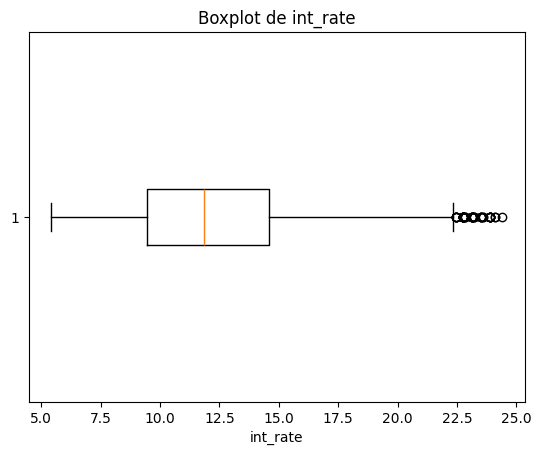

In [41]:
for col in num_cols:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()


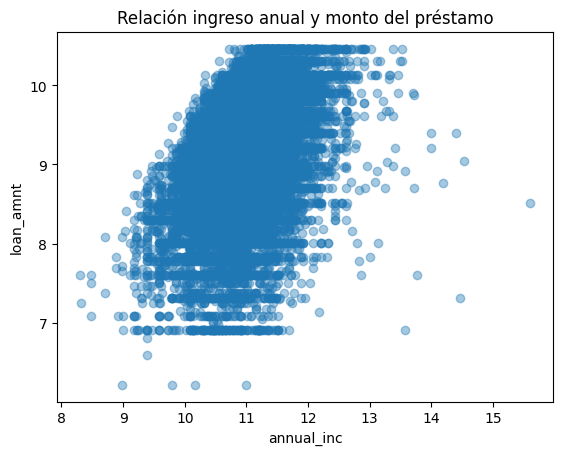

In [48]:
plt.figure()
plt.scatter(df_1["annual_inc"], df_1["loan_amnt"], alpha=0.4)
plt.xlabel("annual_inc")
plt.ylabel("loan_amnt")
plt.title("Relación ingreso anual y monto del préstamo")
plt.show()


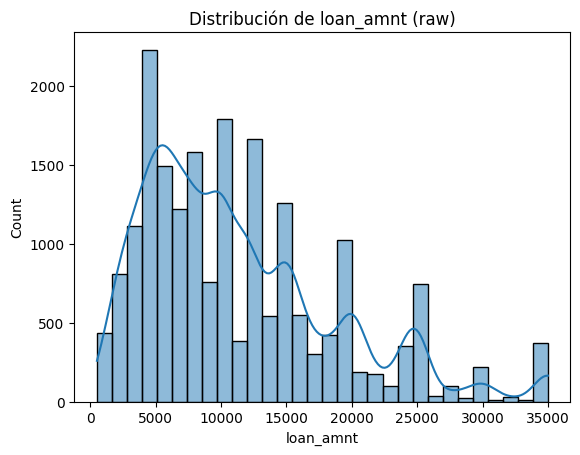

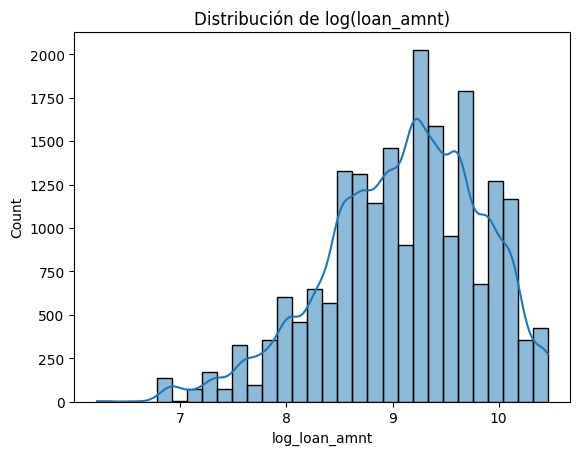

In [44]:
# loan_amnt (raw)
plt.figure()
sns.histplot(df_3["loan_amnt"].dropna(), bins=30, kde=True)
plt.title("Distribución de loan_amnt (raw)")
plt.xlabel("loan_amnt")
plt.show()

# log_loan_amnt
plt.figure()
sns.histplot(df_3["log_loan_amnt"].dropna(), bins=30, kde=True)
plt.title("Distribución de log(loan_amnt)")
plt.xlabel("log_loan_amnt")
plt.show()



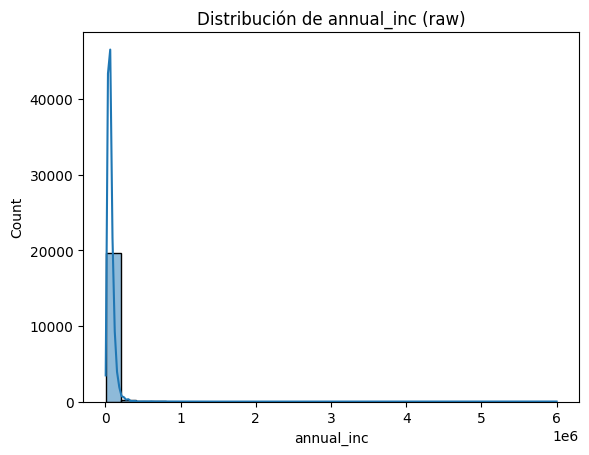

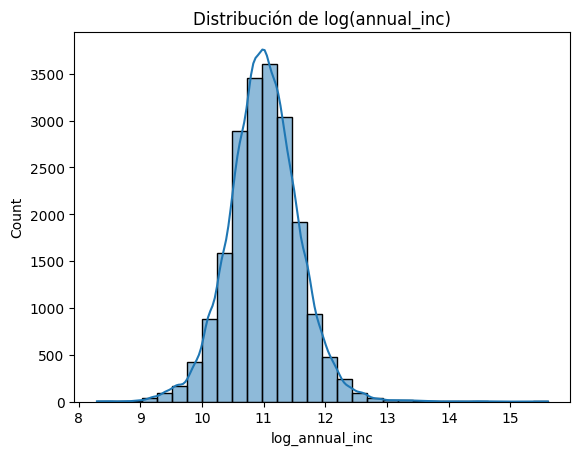

In [49]:
# annual_inc (raw)
plt.figure()
sns.histplot(df_3["annual_inc"].dropna(), bins=30, kde=True)
plt.title("Distribución de annual_inc (raw)")
plt.xlabel("annual_inc")
plt.show()

# log_annual_inc
plt.figure()
sns.histplot(df_3["log_annual_inc"].dropna(), bins=30, kde=True)
plt.title("Distribución de log(annual_inc)")
plt.xlabel("log_annual_inc")
plt.show()


#La variable ya estaba “bien comportada” antes del log.

No tenía un sesgo fuerte

No tenía colas largas extremas

No estaba dominada por valores muy grandes

Por eso, al aplicar log la forma del histograma no cambia mucho. Se sigue viéndose aproximadamente simétrica. En otras palabras, la transformación logarítmica no modifica sustancialmente la distribución, lo que indica que la variable ya presentaba una forma aproximadamente simétrica. En consecuencia, el log no aporta una mejora clara en términos de reducción de sesgo.

#**Categoricas**

#**cardinalidad**

In [51]:
#cantidad de cateogiras en cada columna (cardinalidad)
card_cat = (
    df_1[cat_cols]
    .nunique(dropna=False)
    .sort_values(ascending=False)
    .to_frame("n_unique")
)

card_cat


,n_unique
emp_title,14933
purpose,15
emp_length,12
addr_state,9
grade,7
home_ownership,6
verification_status,4
loan_status,3


#**Top-10 valores más frecuentes (variables categoricas)**

In [52]:
for col in cat_cols:
    print(f"\nVariable: {col}")

    # Conteo de los 10 valores más frecuentes (incluyendo "Missing")
    top_values = df_1[col].value_counts().head(10)

    # Porcentaje de esos valores
    top_percent = df_1[col].value_counts(normalize=True).head(10) * 100

    # Crear tabla con count y percent
    top_table = pd.DataFrame({
        "count": top_values,
        "percent": top_percent
    })

    # Mostrar la tabla
    print(top_table)



Variable: grade
       count  percent
grade                
B       6065  30.4651
A       4875  24.4876
C       4087  20.5294
D       2748  13.8035
E       1434   7.2031
F        540   2.7125
G        159   0.7987

Variable: emp_title
                     count  percent
emp_title                          
Missing               1186   5.9574
Bank of America         53   0.2662
Kaiser Permanente       50   0.2512
State of California     43   0.2160
US Army                 41   0.2059
AT&T                    36   0.1808
JP Morgan Chase         27   0.1356
IBM                     26   0.1306
Verizon                 24   0.1206
UPS                     23   0.1155

Variable: emp_length
            count  percent
emp_length                
10+ years    4249  21.3432
< 1 year     2304  11.5732
2 years      2218  11.1412
3 years      2108  10.5887
4 years      1871   9.3982
5 years      1649   8.2831
1 year       1636   8.2178
6 years      1151   5.7816
7 years       867   4.3550
8 years      

#**5.- EDA bivariado: variables explicativas vs target**

In [53]:
df_1["default"] = (df_1["loan_status"] == "Charged Off").astype(int)

**5.2.1.- Numéricas vs Target**

**boxplots**

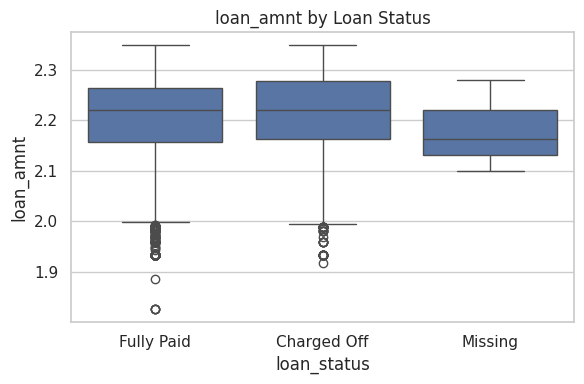

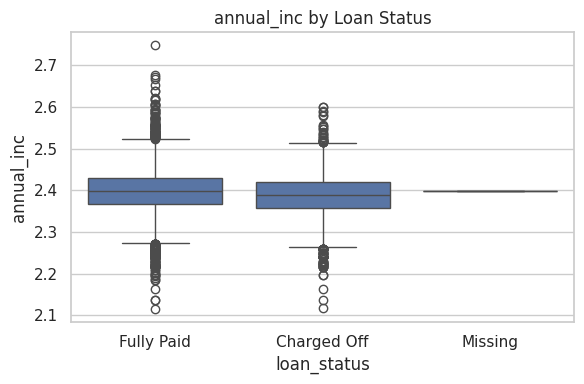

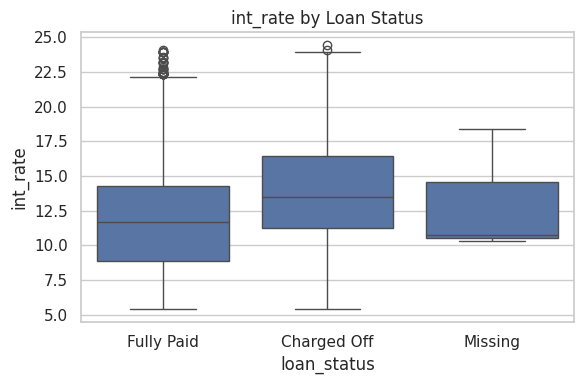

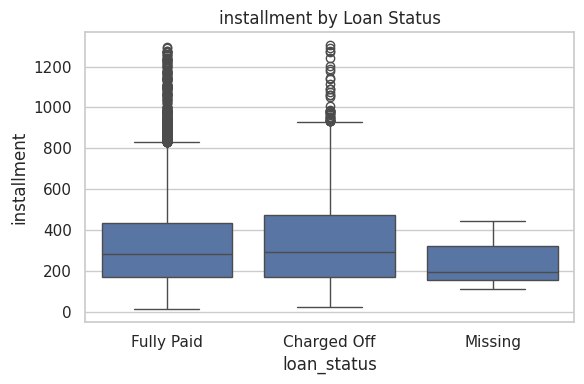

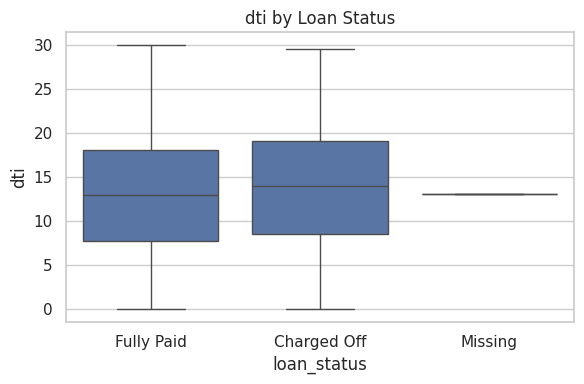

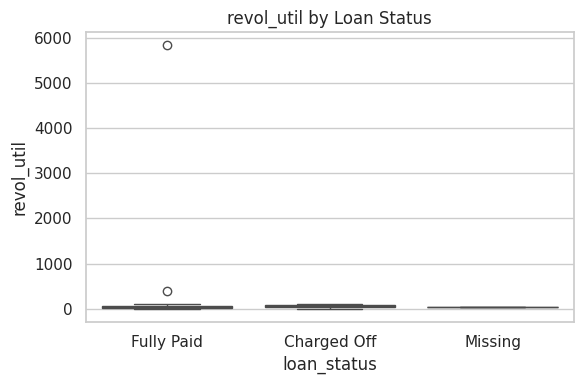

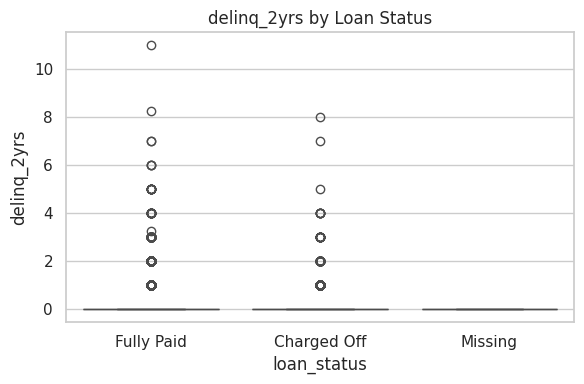

In [ ]:
for var in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_1, x="loan_status", y=var)
    plt.title(f"{var} by Loan Status")
    plt.tight_layout()
    plt.show()

**TABLAS: tasa de default por buckets (quintiles)**

In [54]:
bucket_results = {}

for var in num_cols:
    try:
        df_1[f"{var}_bucket"] = pd.qcut(df_1[var], q=5, duplicates="drop")

        table = (
            df_1
            .groupby(f"{var}_bucket")
            .agg(
                default_rate=("default", "mean"),
                n=("default", "size")
            )
        )

        bucket_results[var] = table

        print(f"\n=== {var} ===")
        display(table)

    except ValueError:
        print(f"\n{var}: no se pudo crear buckets (valores repetidos o constantes)")



=== loan_amnt ===


/tmp/ipython-input-2480484880.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(f"{var}_bucket")


,default_rate,n
loan_amnt_bucket,,
"(6.2139999999999995, 8.517]",0.1479,4577
"(8.517, 8.987]",0.1252,4001
"(8.987, 9.393]",0.1323,4436
"(9.393, 9.741]",0.1480,2986
"(9.741, 10.463]",0.1883,3908



=== dti ===


/tmp/ipython-input-2480484880.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(f"{var}_bucket")


,default_rate,n
dti_bucket,,
"(-0.001, 6.65]",0.1338,3999
"(6.65, 11.02]",0.1329,3966
"(11.02, 15.02]",0.1433,3992
"(15.02, 19.44]",0.1579,3978
"(19.44, 29.99]",0.1714,3973



=== int_rate ===


/tmp/ipython-input-2480484880.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(f"{var}_bucket")


,default_rate,n
int_rate_bucket,,
"(5.419, 8.32]",0.0546,3993
"(8.32, 10.99]",0.1121,4060
"(10.99, 12.99]",0.1517,4040
"(12.99, 15.28]",0.1686,3897
"(15.28, 24.4]",0.2552,3918


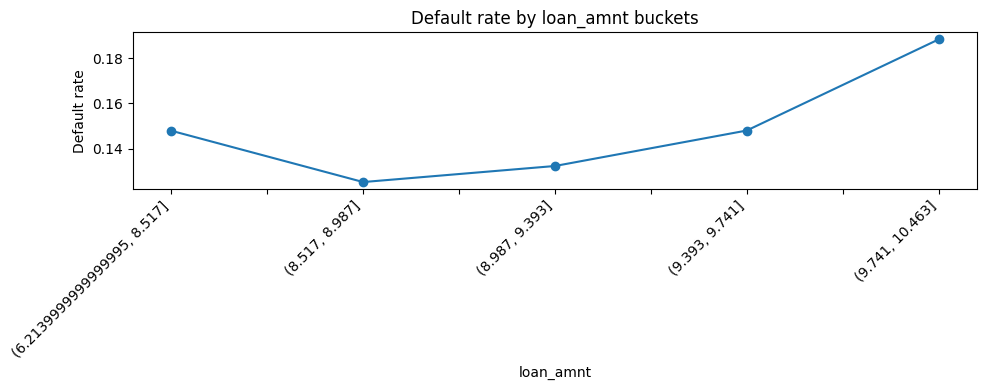

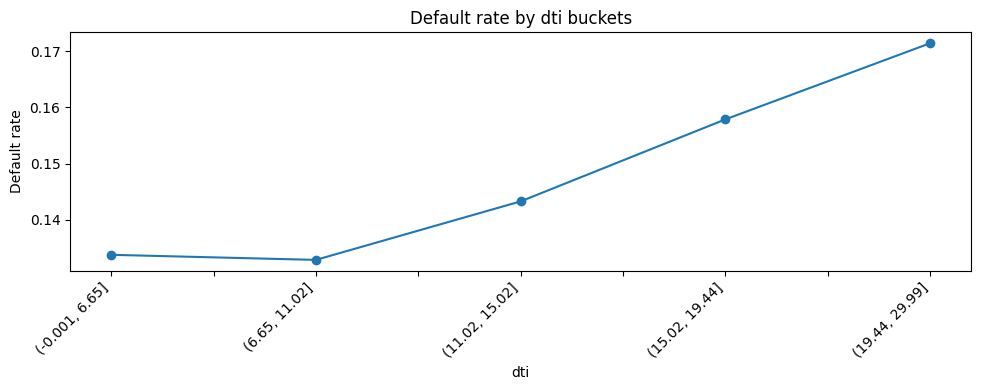

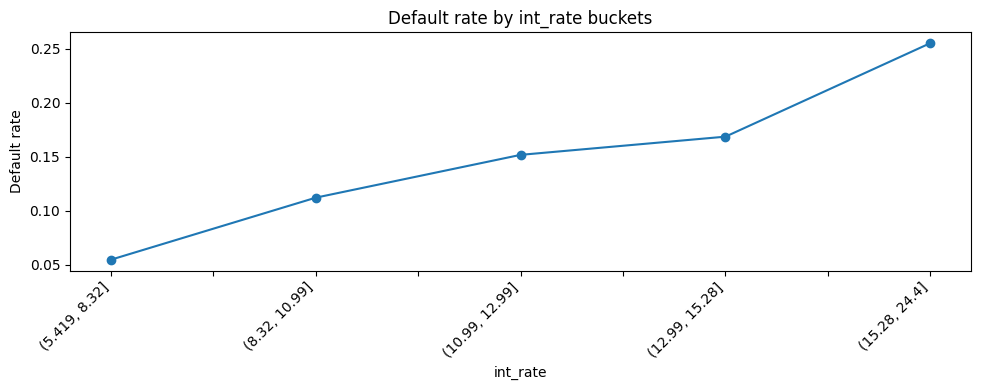

In [55]:
for var, table in bucket_results.items():
    plt.figure(figsize=(10,4))   # ← eje X más largo
    table["default_rate"].plot(marker="o")

    plt.title(f"Default rate by {var} buckets")
    plt.ylabel("Default rate")
    plt.xlabel(var)

    plt.xticks(rotation=45, ha="right")  # ← rotar etiquetas
    plt.tight_layout()
    plt.show()



**5.2.2.- Categóricas vs Target**

In [56]:
cat_tables = {}

for col in cat_cols:
    table = (
        df_1
        .groupby(col)
        .agg(
            default_rate=("default", "mean"),
            n=("default", "size")
        )
        .sort_values("default_rate", ascending=False)
    )

    cat_tables[col] = table

    print(f"\n=== {col} ===")
    display(table)



=== grade ===


,default_rate,n
grade,,
G,0.3585,159
F,0.3222,540
E,0.2636,1434
D,0.2107,2748
C,0.1644,4087
B,0.1284,6065
A,0.0624,4875



=== emp_title ===


,default_rate,n
emp_title,,
E-gain Technologies,1.0000,1
EDCO Waste & Recycling,1.0000,1
EDG Developmet Group,1.0000,1
Total technology Solutions,1.0000,1
EDUCATORS INC. Private Christain Schools,1.0000,1
...,...,...
Hill Wallack,0.0000,1
Hillsborough Community College,0.0000,1
Hillsborough County Public Schools,0.0000,1



=== emp_length ===


,default_rate,n
emp_length,,
Missing,0.2072,502
10+ years,0.1629,4249
5 years,0.1565,1649
6 years,0.1546,1151
8 years,0.1518,718
7 years,0.1499,867
1 year,0.1479,1636
4 years,0.1422,1871
< 1 year,0.1372,2304



=== home_ownership ===


,default_rate,n
home_ownership,,
OTHER,0.1818,44
OWN,0.1585,1546
RENT,0.1524,10965
MORTGAGE,0.1387,7349
Missing,0.0000,3
NONE,0.0000,1



=== verification_status ===


,default_rate,n
verification_status,,
Verified,0.1680,6464
Source Verified,0.1479,5185
Not Verified,0.1320,8256
Missing,0.0000,3



=== loan_status ===


,default_rate,n
loan_status,,
Charged Off,1.0000,2943
Fully Paid,0.0000,16962
Missing,0.0000,3



=== purpose ===


,default_rate,n
purpose,,
small_business,0.2718,905
educational,0.1988,161
house,0.1761,176
moving,0.1703,317
other,0.1564,2059
debt_consolidation,0.1544,9387
medical,0.1457,350
vacation,0.1407,199
renewable_energy,0.1373,51



=== addr_state ===


,default_rate,n
addr_state,,
FL,0.1774,2870
CA,0.1593,7101
NJ,0.1520,1855
NY,0.1314,3813
IL,0.1298,1525
TX,0.1178,2733
106xx,0.0000,1
951xx,0.0000,1
Missing,0.0000,9


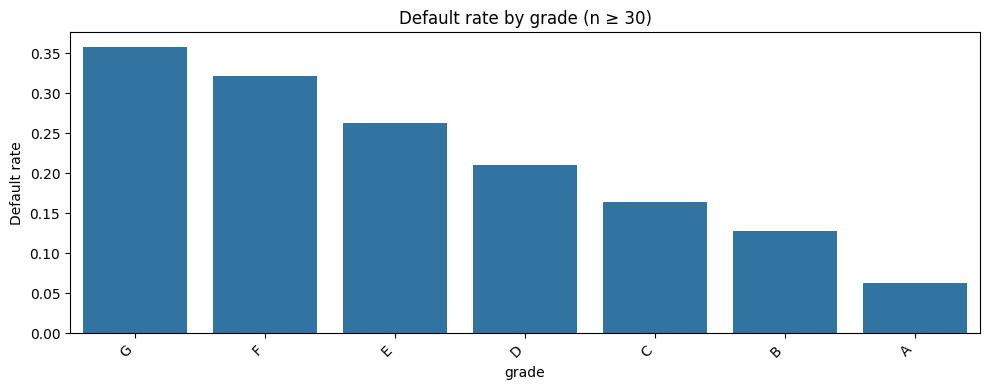

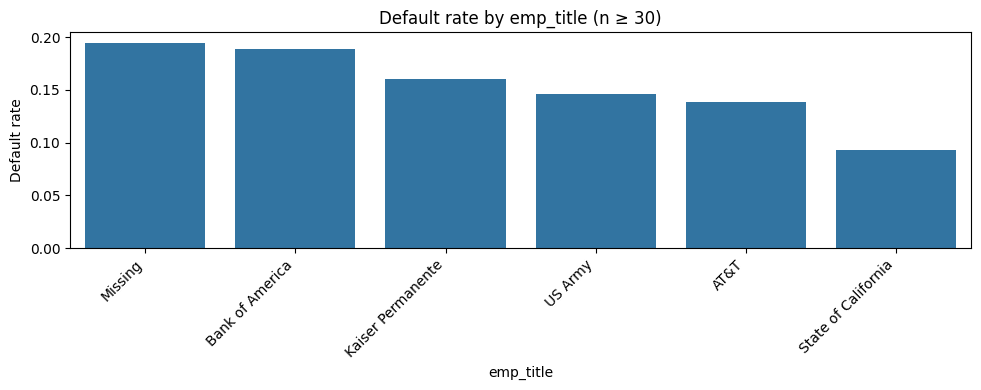

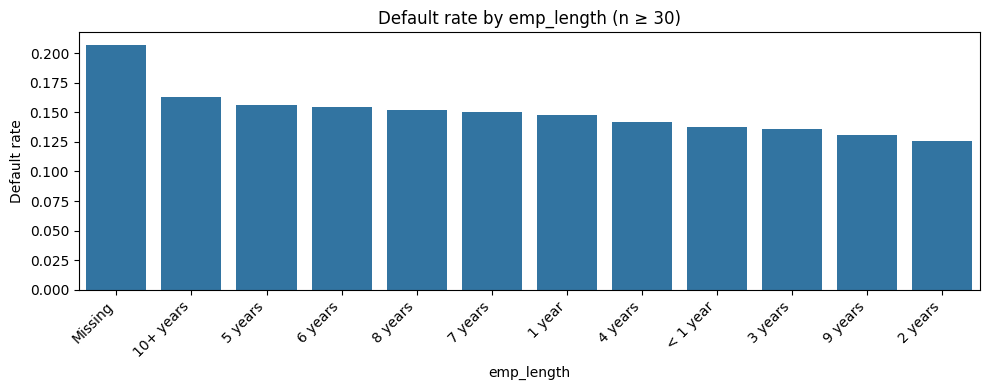

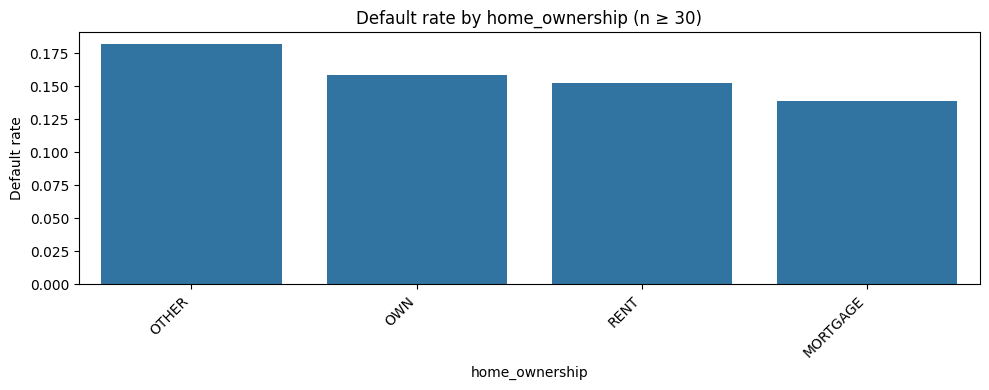

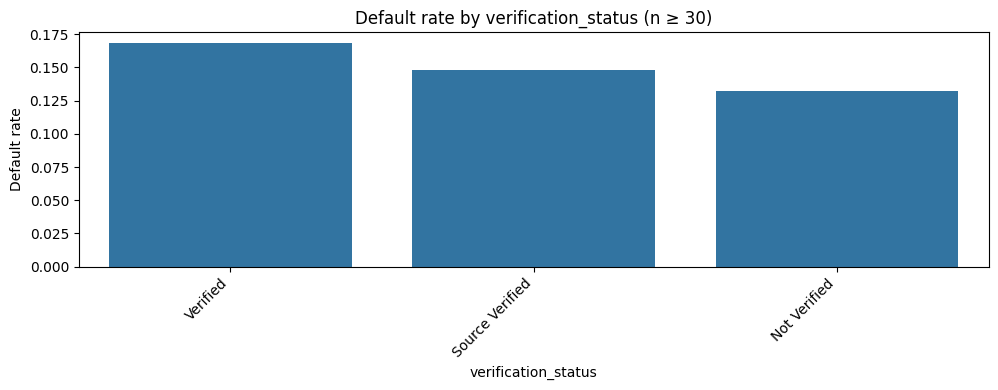

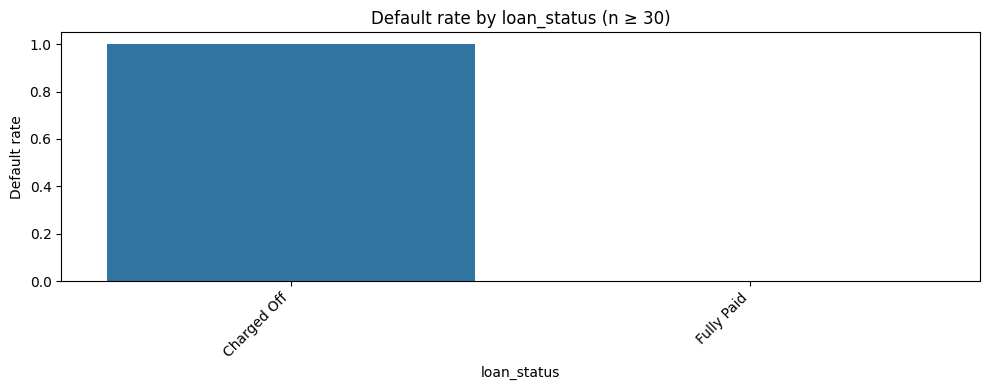

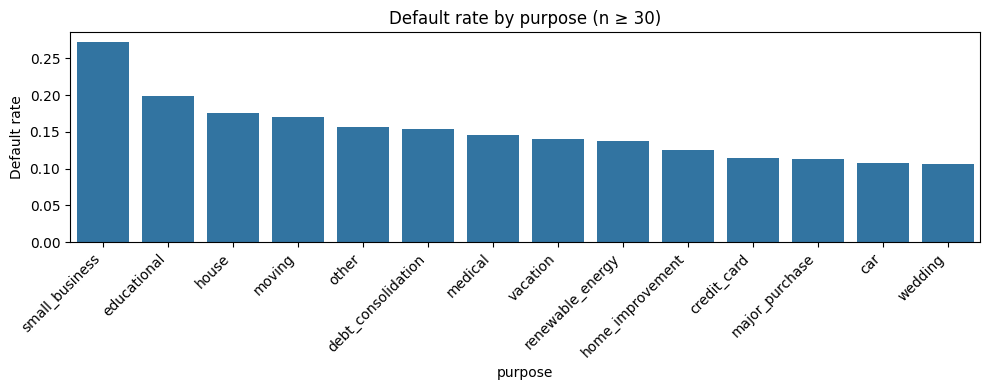

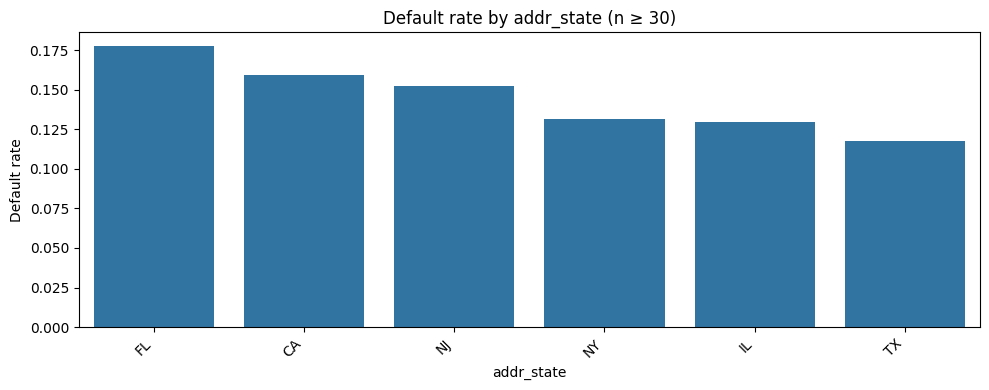

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

MIN_N = 30

for col, table in cat_tables.items():
    plot_data = table[table["n"] >= MIN_N].reset_index()

    if plot_data.empty:
        continue

    plt.figure(figsize=(10,4))
    sns.barplot(
        data=plot_data,
        x=col,
        y="default_rate"
    )
    plt.title(f"Default rate by {col} (n ≥ {MIN_N})")
    plt.ylabel("Default rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


**Registro por categoria**

In [58]:
for col in cat_cols:
    counts = df_1.groupby(col).size().sort_values(ascending=False)

    print(f"\n=== Registros por categoría: {col} ===")
    display(counts)


=== Registros por categoría: grade ===


,0
grade,
B,6065
A,4875
C,4087
D,2748
E,1434
F,540
G,159



=== Registros por categoría: emp_title ===


,0
emp_title,
Missing,1186
Bank of America,53
Kaiser Permanente,50
State of California,43
US Army,41
...,...
Harrahs Casino,1
Harrahs Entertainment,1
Harrington College of Design,1



=== Registros por categoría: emp_length ===


,0
emp_length,
10+ years,4249
< 1 year,2304
2 years,2218
3 years,2108
4 years,1871
5 years,1649
1 year,1636
6 years,1151
7 years,867



=== Registros por categoría: home_ownership ===


,0
home_ownership,
RENT,10965
MORTGAGE,7349
OWN,1546
OTHER,44
Missing,3
NONE,1



=== Registros por categoría: verification_status ===


,0
verification_status,
Not Verified,8256
Verified,6464
Source Verified,5185
Missing,3



=== Registros por categoría: loan_status ===


,0
loan_status,
Fully Paid,16962
Charged Off,2943
Missing,3



=== Registros por categoría: purpose ===


,0
purpose,
debt_consolidation,9387
credit_card,2696
other,2059
home_improvement,1330
major_purchase,1048
small_business,905
car,687
wedding,539
medical,350



=== Registros por categoría: addr_state ===


,0
addr_state,
CA,7101
NY,3813
FL,2870
TX,2733
NJ,1855
IL,1525
Missing,9
106xx,1
951xx,1
